## Практическое задание:

In [180]:
from xgboost import XGBClassifier
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [189]:
import pandas as pd

dataset = pd.read_csv('breast-cancer-wisconsin.data')

dataset.columns = ['Id', 'Clump_thickness', 'Uniformity_cell_size', 'Uniformity_cell_shape', 'Marginal_adhesion', 'Single_e_cell_size', 'Bare_nuclei', 'Bland_chromatin', 'Normal_nucleoli', 'Mitoses', 'Class']

dataset

,Id,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_adhesion,Single_e_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,1002945,5,4,4,5,7,10,3,2,1,2
1,1015425,3,1,1,1,2,2,3,1,1,2
2,1016277,6,8,8,1,3,4,3,7,1,2
3,1017023,4,1,1,3,2,1,3,1,1,2
4,1017122,8,10,10,8,7,10,9,7,1,4
...,...,...,...,...,...,...,...,...,...,...,...
693,776715,3,1,1,1,3,2,1,1,1,2
694,841769,2,1,1,1,2,1,1,1,1,2
695,888820,5,10,10,3,7,3,8,10,2,4
696,897471,4,8,6,4,3,4,10,6,1,4


- сделать обзорный анализ выбранного датасета

## Attribute Information:

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)



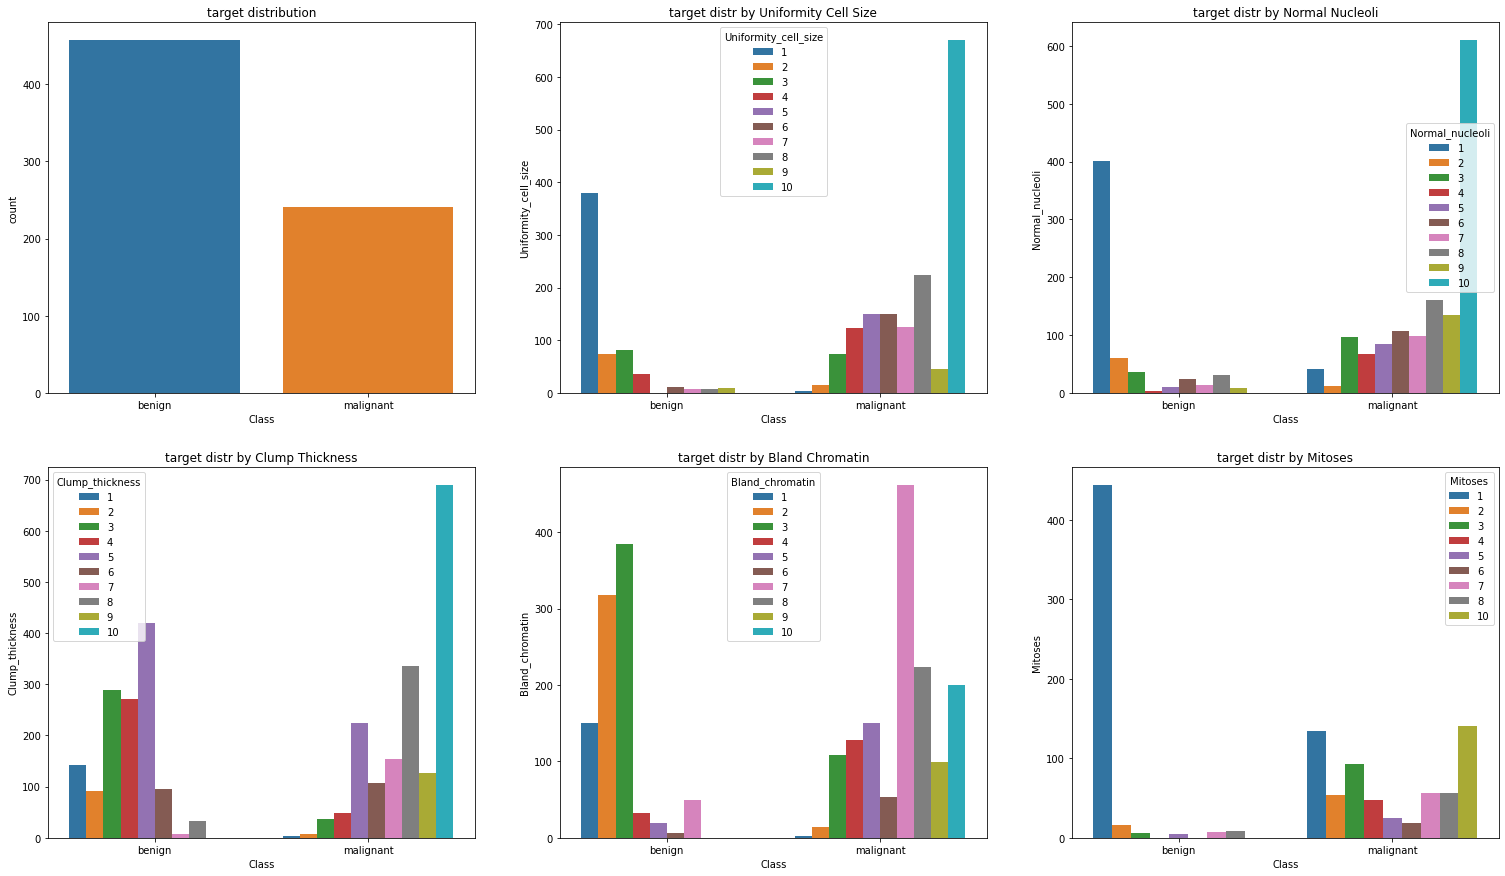

In [183]:
d = dataset.copy()
d['Class'].replace({2: 'benign', 4: 'malignant'}, inplace=True)
fig, ax = plt.subplots(2, 3, figsize=(26, 15))

sns.countplot(x=d.Class, ax=ax[0][0]);
ax[0][0].set_title('target distribution')

sns.barplot(data=d, x="Class", y="Uniformity_cell_size", estimator=np.sum, hue='Uniformity_cell_size', ax=ax[0][1]);
ax[0][1].set_title('target distr by Uniformity Cell Size');

sns.barplot(data=d, x="Class", y="Normal_nucleoli", estimator=np.sum, hue='Normal_nucleoli', ax=ax[0][2]);
ax[0][2].set_title('target distr by Normal Nucleoli');

sns.barplot(data=d, x="Class", y="Clump_thickness", estimator=np.sum, hue='Clump_thickness', ax=ax[1][0]);
ax[1][0].set_title('target distr by Clump Thickness');

sns.barplot(data=d, x="Class", y="Mitoses", estimator=np.sum, hue='Mitoses', ax=ax[1][2]);
ax[1][2].set_title('target distr by Mitoses');

sns.barplot(data=d, x="Class", y="Bland_chromatin", estimator=np.sum, hue='Bland_chromatin', ax=ax[1][1]);
ax[1][1].set_title('target distr by Bland Chromatin');

- сделать feature engineering

In [190]:
dataset.drop('Id', axis=1, inplace=True)

In [191]:
dataset.head()

,Clump_thickness,Uniformity_cell_size,Uniformity_cell_shape,Marginal_adhesion,Single_e_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Class
0,5,4,4,5,7,10,3,2,1,2
1,3,1,1,1,2,2,3,1,1,2
2,6,8,8,1,3,4,3,7,1,2
3,4,1,1,3,2,1,3,1,1,2
4,8,10,10,8,7,10,9,7,1,4


In [192]:
print('Dataset Uniques:')
for col in dataset.columns:
    print(col+':', sorted(dataset[col].unique()))

Dataset Uniques:
Clump_thickness: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Uniformity_cell_size: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Uniformity_cell_shape: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Marginal_adhesion: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Single_e_cell_size: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Bare_nuclei: ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9', '?']
Bland_chromatin: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Normal_nucleoli: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Mitoses: [1, 2, 3, 4, 5, 6, 7, 8, 10]
Class: [2, 4]


In [193]:
dataset.loc[dataset.Bare_nuclei == '?'].shape

(16, 10)

In [194]:
dataset['Bare_nuclei'].replace('?', dataset.Bare_nuclei.mode()[0], 
                               inplace=True)

In [195]:
dataset = dataset.astype(int)

- обучить любой классификатор (какой вам нравится)

In [196]:
def evaluate_results(y_test, y_predict):
    
    print('=== Classification results ===')
    
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    
    acc = accuracy_score(y_test, y_predict)
    print('accuracy: %.2f%%' % (acc * 100.0))
    
    conf_matrix = confusion_matrix(y_test, y_predict)
    print('confusion matrix:\n', conf_matrix)
    
    return f1, roc, rec, prc, acc, conf_matrix

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

X, y = dataset.drop('Class', axis=1), dataset.Class.replace({2: 0, 4: 1})

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=7)

model = XGBClassifier(eval_metric='auc',
                          use_label_encoder=False,
                          random_state=42)

model.fit(X_train, y_train)

y_predict = model.predict(X_test)

results = evaluate_results(y_test, y_predict)


=== Classification results ===
f1: 93.07%
roc: 94.06%
recall: 90.38%
precision: 95.92%
accuracy: 95.00%
confusion matrix:
 [[86  2]
 [ 5 47]]


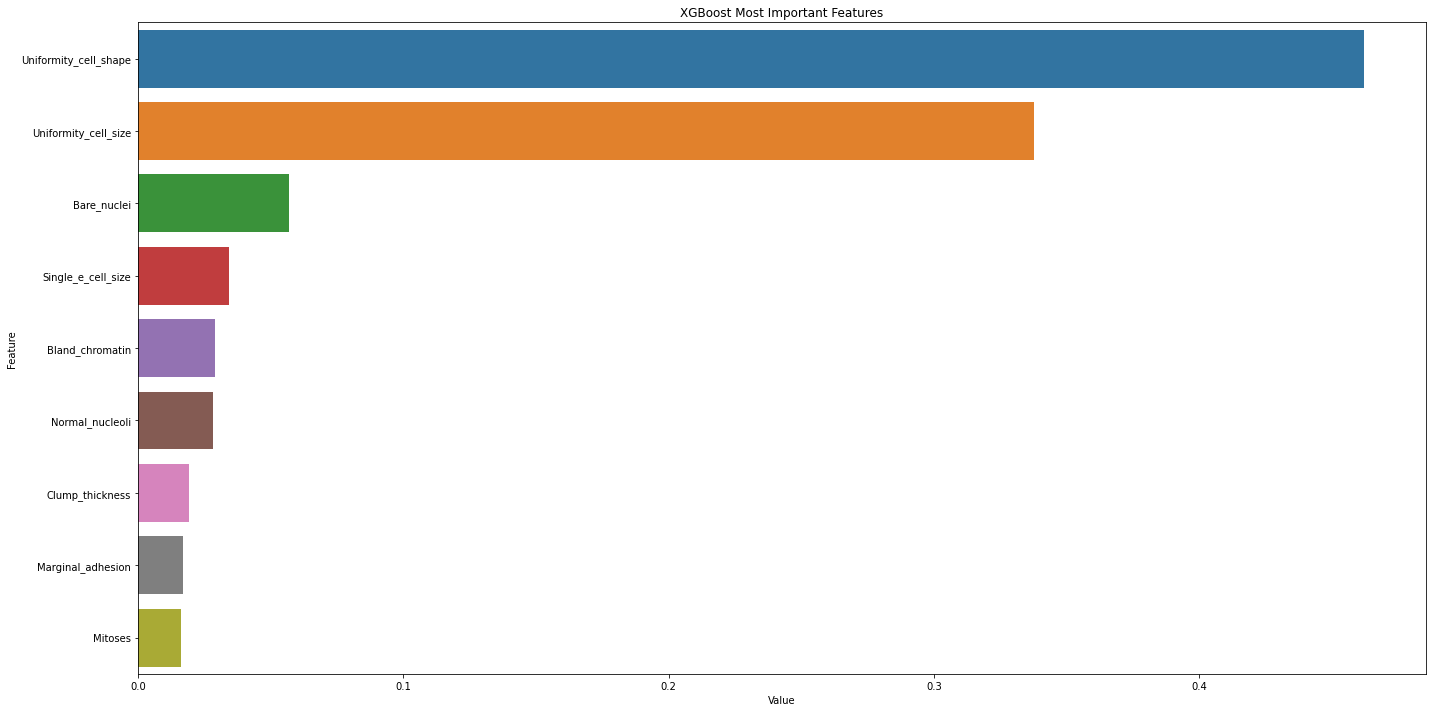

In [208]:
# plot model builtin feature importances

cols = X_train.columns
feature_imp=pd.DataFrame(sorted(zip(model.feature_importances_,cols)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:10])
plt.title('XGBoost Most Important Features')
plt.tight_layout()
plt.show()

- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%

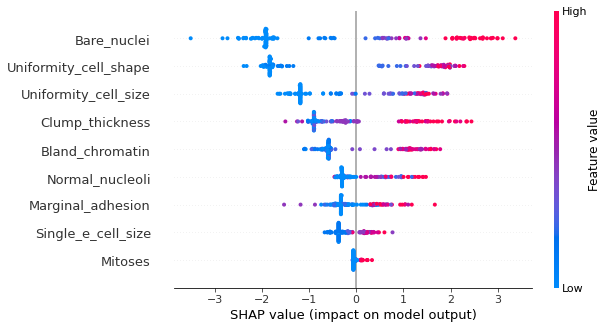

In [213]:
shap.summary_plot(shap_values, X_test)

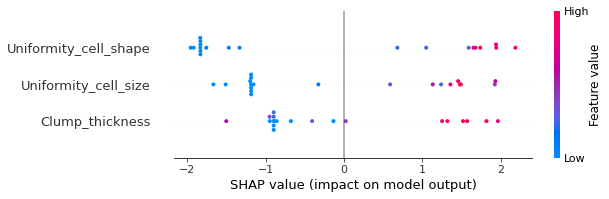

In [249]:
shap.summary_plot(shap_values[:20, :3], X_test.iloc[:20, :3])

- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [230]:
import warnings
warnings.filterwarnings('ignore')

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[7,:10], X_test.iloc[7,:10])

_Здесь совсем всё очевидно получилось - чем выше любое из значений признаков, тем выше вероятность класса 1._

Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 